<a href="https://colab.research.google.com/github/Gamila-Elfayoumi/Neural-Networks/blob/main/Weather_project_GRU_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

In [2]:
# ============================
# Data Loading & Preprocessing
# ============================
# Load the weather dataset. Adjust the file path as needed.
data = pd.read_csv('/content/drive/MyDrive/Data Set/weatherHistory.csv')

# Print an initial preview and data info.
print("Initial Data Preview:")
print(data.head())
print("\nData Info:")
print(data.info())


Initial Data Preview:
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0  

In [3]:
# Select the relevant numerical features.
cols = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)']
data = data[cols]

# Fill missing values by forward filling and then backward filling.
data = data.ffill().bfill()

print("\nData Info After Preprocessing:")
print(data.info())


Data Info After Preprocessing:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature (C)       96453 non-null  float64
 1   Humidity              96453 non-null  float64
 2   Wind Speed (km/h)     96453 non-null  float64
 3   Visibility (km)       96453 non-null  float64
 4   Pressure (millibars)  96453 non-null  float64
dtypes: float64(5)
memory usage: 3.7 MB
None


In [4]:

# Ensure a temperature column exists (case-insensitive search).
temp_col = None
for col in data.columns:
    if 'temp' in col.lower():
        temp_col = col
        break
if temp_col is None:
    raise ValueError("No temperature column found in the dataset.")


In [5]:
# ============================
# Data Normalization & Sequence Creation
# ============================
# Convert the DataFrame to a numpy array and normalize the values between 0 and 1.
scaler = MinMaxScaler()
data_array = data.values.astype(np.float32)
data_scaled = scaler.fit_transform(data_array)

def create_sequences(data, seq_length, target_col_idx=0):
    """
    Create time-series sequences from the data.

    Each sequence of length 'seq_length' is used to predict the next value
    from the target column.

    Parameters:
    - data: numpy array of shape (num_samples, num_features)
    - seq_length: length of each input sequence
    - target_col_idx: index of the target feature (default is 0 for Temperature)

    Returns:
    - xs: numpy array of input sequences of shape (num_samples - seq_length, seq_length, num_features)
    - ys: numpy array of target values of shape (num_samples - seq_length,)
    """
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, target_col_idx]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10  # You can adjust this window size.
X, y = create_sequences(data_scaled, seq_length, target_col_idx=0)

# Split the sequences into training (80%) and testing (20%) sets.
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test   = X[train_size:], y[train_size:]


In [6]:
# ============================
# PyTorch Dataset & DataLoader Creation
# ============================
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset class for time-series data.

    Converts numpy arrays into torch tensors.
    """
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # Shape: (samples, seq_length, num_features)
        self.y = torch.from_numpy(y).unsqueeze(-1)  # Shape: (samples, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 128
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset  = TimeSeriesDataset(X_test, y_test)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# ============================
# Define the GRU Model
# ============================
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.1):
        """
        GRU-based model for time-series forecasting.

        Parameters:
        - input_size: Number of features per time step.
        - hidden_size: Number of units in the GRU hidden layer.
        - num_layers: Number of stacked GRU layers.
        - output_size: Number of outputs (e.g., 1 for temperature).
        - dropout: Dropout probability between GRU layers.
        """
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the GRU layer; 'batch_first=True' expects input shape (batch, seq_length, input_size)
        self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        # Fully connected layer to map GRU output to final prediction.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass for the GRU model.

        Parameters:
        - x: Input tensor of shape (batch, seq_length, input_size)

        Returns:
        - out: Prediction tensor of shape (batch, output_size)
        """
        # Initialize hidden state with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate through GRU layers.
        out, _ = self.gru(x, h0)
        # Use the output from the last time step.
        out = out[:, -1, :]
        # Map through the fully connected layer.
        out = self.fc(out)
        return out


In [8]:
# ============================
# Training and Evaluation Functions
# ============================
def compute_epoch_accuracy(model, loader, device, tolerance=0.1):
    """
    Compute accuracy as the percentage of predictions within a specified tolerance.

    Parameters:
    - model: Trained model.
    - loader: DataLoader for evaluation data.
    - device: CPU or GPU device.
    - tolerance: Allowed difference between prediction and true value.

    Returns:
    - Accuracy percentage.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            correct += (torch.abs(outputs - y_batch) < tolerance).sum().item()
            total += y_batch.numel()
    return (correct / total) * 100

def train_and_evaluate_with_scheduler(model, train_loader, test_loader, criterion, optimizer,
                                      scheduler, num_epochs, device, tolerance=0.1, early_stopping_patience=10):
    """
    Train the GRU model with learning rate scheduling and early stopping.

    Parameters:
    - model: GRU model.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for testing data.
    - criterion: Loss function.
    - optimizer: Optimization algorithm.
    - scheduler: Learning rate scheduler.
    - num_epochs: Total number of epochs.
    - device: CPU or GPU device.
    - tolerance: Tolerance for accuracy calculation.
    - early_stopping_patience: Number of epochs to wait for improvement before stopping.

    Returns:
    - Lists of training losses, training accuracies, testing losses, and testing accuracies.
    """
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training loop.
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_acc = compute_epoch_accuracy(model, train_loader, device, tolerance)
        train_accuracies.append(train_acc)

        # Evaluation loop on test set.
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                running_loss += loss.item() * X_batch.size(0)
        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)
        test_acc = compute_epoch_accuracy(model, test_loader, device, tolerance)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_acc:.2f}%, " +
              f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_acc:.2f}%")

        # Scheduler step: adjust learning rate based on test loss.
        scheduler.step(epoch_test_loss)

        # Early stopping check.
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_gru_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    return train_losses, train_accuracies, test_losses, test_accuracies

def plot_loss_and_accuracy(train_losses, test_losses, train_acc, test_acc, num_epochs):
    """
    Plot training and testing loss and accuracy over epochs using subplots.
    """
    epochs = range(1, num_epochs + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Loss.
    axes[0].plot(epochs, train_losses, marker='o', linestyle='-', linewidth=2, label='Train Loss', color='blue')
    axes[0].plot(epochs, test_losses, marker='s', linestyle='--', linewidth=2, label='Test Loss', color='red')
    axes[0].set_xlabel('Epoch', fontsize=14)
    axes[0].set_ylabel('Loss', fontsize=14)
    axes[0].set_title('Loss vs Epochs', fontsize=16)
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].legend(fontsize=12)

    # Plot Accuracy.
    axes[1].plot(epochs, train_acc, marker='o', linestyle='-', linewidth=2, label='Train Accuracy', color='green')
    axes[1].plot(epochs, test_acc, marker='s', linestyle='--', linewidth=2, label='Test Accuracy', color='orange')
    axes[1].set_xlabel('Epoch', fontsize=14)
    axes[1].set_ylabel('Accuracy (%)', fontsize=14)
    axes[1].set_title('Accuracy vs Epochs', fontsize=16)
    axes[1].grid(True, linestyle='--', alpha=0.5)
    axes[1].legend(fontsize=12)

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Training GRU Model with Optimized Parameters...
Epoch 1/20: Train Loss: 0.1249, Train Acc: 46.12%, Test Loss: 0.0246, Test Acc: 50.18%
Epoch 2/20: Train Loss: 0.0187, Train Acc: 52.56%, Test Loss: 0.0134, Test Acc: 58.38%
Epoch 3/20: Train Loss: 0.0156, Train Acc: 56.43%, Test Loss: 0.0115, Test Acc: 63.79%
Epoch 4/20: Train Loss: 0.0132, Train Acc: 62.34%, Test Loss: 0.0095, Test Acc: 69.30%
Epoch 5/20: Train Loss: 0.0108, Train Acc: 68.54%, Test Loss: 0.0079, Test Acc: 74.06%
Epoch 6/20: Train Loss: 0.0086, Train Acc: 74.92%, Test Loss: 0.0065, Test Acc: 78.66%
Epoch 7/20: Train Loss: 0.0066, Train Acc: 82.01%, Test Loss: 0.0050, Test Acc: 84.01%
Epoch 8/20: Train Loss: 0.0049, Train Acc: 89.46%, Test Loss: 0.0035, Test Acc: 90.69%
Epoch 9/20: Train Loss: 0.0036, Train Acc: 94.18%, Test Loss: 0.0024, Test Acc: 95.41%
Epoch 10/20: Train Loss: 0.0028, Train Acc: 96.80%, Test Loss: 0.0018, Test Acc: 97.74%
Epoch 11/20: Train Loss: 0.0023, Train Acc: 97.86%, Test Loss: 0.0015, Test Acc:

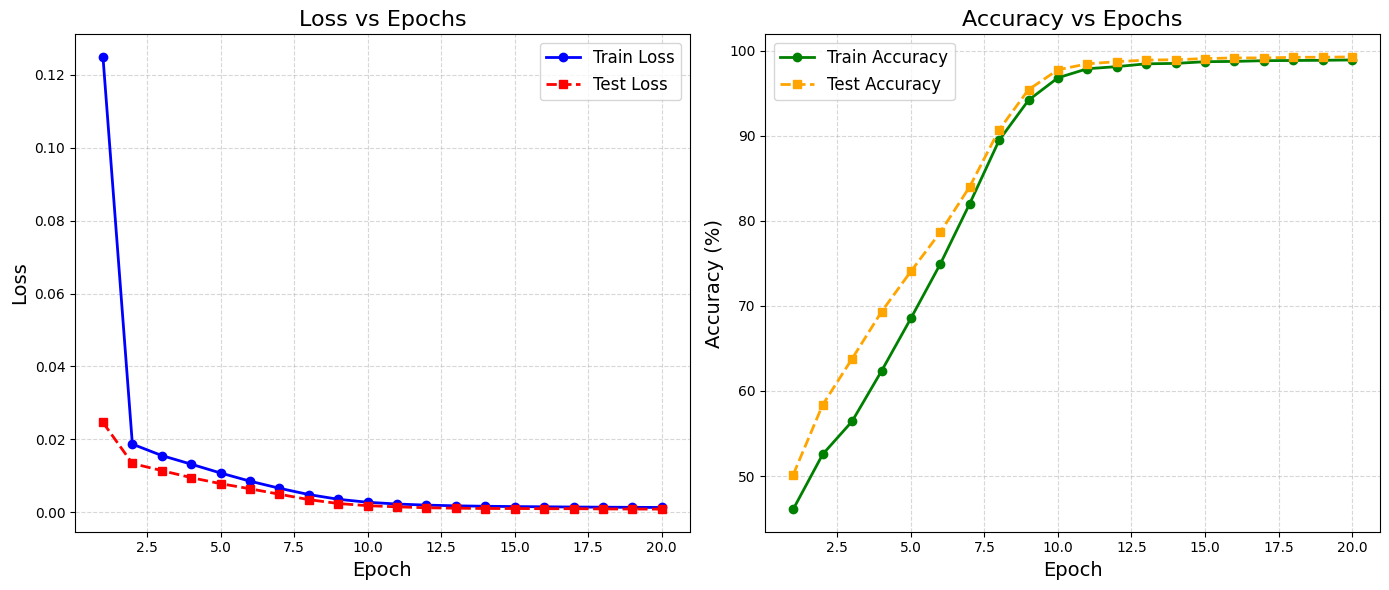

In [9]:
# ============================
# Model Training with Optimized Parameters
# ============================
# Set hyperparameters for the GRU model.
input_size = 5         # Number of features per time step.
hidden_size = 64       # Number of GRU hidden units.
num_layers = 2         # Number of stacked GRU layers.
output_size = 1        # Predicting one output value (temperature).
num_epochs = 20        # Total training epochs.
learning_rate = 0.00001  # Initial learning rate.
weight_decay = 1e-5    # L2 regularization factor.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the GRU model.
gru_model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout=0.1).to(device)
criterion = nn.MSELoss()  # Mean Squared Error loss for regression.
optimizer = optim.Adam(gru_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Learning rate scheduler: reduces LR if test loss plateaus.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print("\nTraining GRU Model with Optimized Parameters...")
train_losses, train_acc, test_losses, test_acc = train_and_evaluate_with_scheduler(
    gru_model, train_loader, test_loader, criterion, optimizer, scheduler,
    num_epochs, device, tolerance=0.1, early_stopping_patience=10
)

# Plot loss and accuracy over epochs.
plot_loss_and_accuracy(train_losses, test_losses, train_acc, test_acc, num_epochs)


In [10]:
# ============================
# Saving and Loading the Model
# ============================
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "weather_gru_model_optimized.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the trained GRU model.
torch.save(gru_model.state_dict(), MODEL_SAVE_PATH)
print(f"Optimized GRU model saved to: {MODEL_SAVE_PATH}")

Optimized GRU model saved to: models/weather_gru_model_optimized.pth


In [11]:
# Reload the model for evaluation (optional).
loaded_gru_model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout=0.1).to(device)
loaded_gru_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_gru_model.eval()

GRUModel(
  (gru): GRU(5, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
 # ============================
# Final Evaluation on Test Data
# ============================
def evaluate_model(model, loader, criterion, device):
    """
    Evaluate the model on the given data loader.

    Returns the average loss over the dataset.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

final_test_loss = evaluate_model(loaded_gru_model, test_loader, criterion, device)
final_test_acc = compute_epoch_accuracy(loaded_gru_model, test_loader, device, tolerance=0.1)
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}%")


Final Test Loss: 0.0009
Final Test Accuracy: 99.25%


In [35]:
# ────────────────────────────────────────────────────────────────────────────
# Load, Evaluate & Predict with Your GRU Model
# ────────────────────────────────────────────────────────────────────────────

import torch
import numpy as np

# 1) Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Hyper-parameters (must match your training settings)
input_size  = 5       # number of features
hidden_size = 64      # the GRU hidden dimension you used
num_layers  = 2       # how many GRU layers you stacked
output_size = 1       # predicting a single temperature value
dropout      = 0.2    # same dropout as training
seq_length   = 10     # sequence length

# 3) Re-define your GRUModel
class GRUModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super().__init__()
        self.gru = torch.nn.GRU(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout
        )
        self.fc  = torch.nn.Linear(hidden_size, output_size)
    def forward(self, x):
        # x: (batch, seq_length, input_size)
        out, _ = self.gru(x)            # out: (batch, seq_length, hidden_size)
        last = out[:, -1, :]            # take last time‐step
        return self.fc(last)            # (batch, output_size)

# 4) Instantiate & load weights
model = GRUModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
model.load_state_dict(
    torch.load("/content/models/weather_gru_model_optimized.pth", map_location=device)
)
model.eval()

# 5) Evaluate on your existing test_loader
test_loss = evaluate_model(model, test_loader, criterion, device)
test_acc  = compute_epoch_accuracy(model, test_loader, device, tolerance=0.1)
print(f" Test   Loss: {test_loss:.4f} \tAccuracy: {test_acc:.2f}%")

# 6) Quick sanity‐check: one batch of raw predictions vs. ground truth
X_batch, y_batch = next(iter(test_loader))
with torch.no_grad():
    Xb, yb = X_batch.to(device), y_batch.to(device)
    preds_norm = model(Xb).cpu().numpy().flatten()
    y_true_norm = yb.cpu().numpy().flatten()

# 7) Invert scaling on those to get °C back
dummy = np.zeros((len(preds_norm), data_scaled.shape[1]), dtype=np.float32)
dummy[:, 0]    = preds_norm         # put your norm’d preds into first col
dummy[:, 1:]   = Xb[:, -1, 1:].cpu().numpy()  # fill other cols with last inputs
inverted = scaler.inverse_transform(dummy)
preds_C = inverted[:, 0]
true_C  = scaler.inverse_transform(
    np.concatenate([yb.cpu().numpy(), np.zeros((len(yb),4))], axis=1)
)[:, 0]

# 8) Print a few comparisons
for i in range(5):
    print(f"True: {true_C[i]:.2f}°C   Pred: {preds_C[i]:.2f}°C")


 Test   Loss: 0.0009 	Accuracy: 99.25%
True: 1.14°C   Pred: 0.32°C
True: 2.22°C   Pred: 0.17°C
True: 2.92°C   Pred: 0.59°C
True: 2.89°C   Pred: 1.71°C
True: 2.93°C   Pred: 2.79°C
